Authors: Allard Marc-Antoine

Course: FIN-407

---

## Sentiment Analysis Benchmark

1. Exploration of the training set


2. Models training:
    1. Word2Vec Embed x GloVe + Classification Algo
    3. LSTM/GRU
    4. RoBERTa
    5. FinBERT


---
### Import

In [1]:
# For Colab
# !pip instal requirements.txt
# !pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import Dataset
import pandas as pd
pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = 'matplotlib'
pd.set_option("display.max_colwidth", 200) 

import plotly.express as px
import numpy as np
from tqdm import tqdm
import statsmodels as sm 
import seaborn as sns 
from sklearn import svm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
%matplotlib inline 

import spacy, nltk, gensim, sklearn, re

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 


---
### Helper func

In [3]:
# ================================================================================================ #
def plot_timeseries(df): 
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract the year and month from the Date column
    df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)

    # Group by YearMonth and count the number of articles for each sentiment label
    monthly_counts = df.groupby(['YearMonth', 'label']).size().reset_index(name='Count')

    # Create a bar plot using Plotly Express with hue for the sentiment label
    fig = px.bar(monthly_counts, 
                 x='YearMonth', 
                 y='Count', 
                 title='Monthly Count of Sentiment-Labeled News Articles', 
                 color='label', 
                 color_discrete_map={'-1': 'red', '0': 'blue', '1': 'green'},
                 labels={'YearMonth': 'Month', 'Count': 'Number of Articles'},
                 category_orders={'label': ['-1', '0', '1']})

    # Update the x-axis tick format and angle for better readability
    fig.update_xaxes(tickangle=-45)

    # Show the plot
    fig.show()

# ================================================================================================ #
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# ================================================================================================ #
def grid_CV(X_train, X_test, y_train, y_test, k=3, undersampling=False):
    "Grid CV methods"

    if undersampling:
        rus = RandomUnderSampler(sampling_strategy={0: 814, 1: 814, 2: 814}, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # Prepare models and params
    model_params = {
        'Logistic Regression': {
            'model': LogisticRegression(solver='saga', max_iter=1000, random_state=42),
            'params': {
                'penalty': ['elasticnet'],
                'C': [0.01, 0.1, 0.2, 0.5, 1, 5],
                'l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [10, 50, 100, 200],
                'max_depth': [None, 10, 20, 30],
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }
        },
        'XGBOOST': {
            'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
            'params': {
                'max_depth': [5, 10, 100],
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': [20, 100, 200]
            }
        }
    }

    # Grid Search with CV
    best_models = {}
    results = []

    for model_name, mp in model_params.items():
        print(f"Training {model_name}...")
        clf = GridSearchCV(mp['model'], mp['params'], cv=k, scoring='f1_weighted', n_jobs=-1, verbose=1)
        clf.fit(X_train, y_train)
        
        best_models[model_name] = clf.best_estimator_
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        result = {
            'Model': model_name,
            'Best Params': clf.best_params_,
            'Test Accuracy': accuracy,
            'Test F1 Score': f1
        }
        results.append(result)
        
        print(f"{model_name} Best Params: {clf.best_params_}")
        print(f"{model_name} Accuracy: {accuracy}")
        print(f"{model_name} F1 Score: {f1}")
        print("===============================")

    # Display results in a structured format
    for result in results:
        print(f"Model: {result['Model']}")
        print(f"Best Params: {result['Best Params']}")
        print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
        print(f"Test F1 Score: {result['Test F1 Score']:.4f}")
        print("===============================")
    
    return results, best_models

# ================================================================================================ #
def show_confusion(results, best_models, X_test, y_test, unique_labels):
    # Results
    best_model_name = max(results, key=lambda x: x['Test F1 Score'])['Model']
    best_model = best_models[best_model_name]

    print(f"Best Model: {best_model_name}")
    print(f"Best Params: {best_model.get_params()}")

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"F1 test {f1_score(y_test, y_pred, average='weighted')}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.show()


---
### Exploration of the training set

In [11]:
training_path = "../../data/news/"
# Load the data
training_news = pd.read_json(training_path+"news_train.jsonl", lines=True)

# Add unique identifier
training_news['id'] = range(1, len(training_news) + 1)
# label to float
training_news['label'] = training_news['label'].astype(float)
# training_news['Date'] = pd.to_datetime(training_news['Date'])

training_news.set_index('id', inplace=True)

training_news.head()

,summary,label
id,,
1,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",-1.0
2,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",0.0
3,Short treasuries via TBT. That 4.7% return on today's long bond would look pretty darn good if deflation hit the USA hard over the next decade or so. The Bottom Line: The bond market pretty much s...,1.0
4,Hard Assets Investor submits: By Brad Zigler Real-time Monetary Inflation (last 12-months): 2.1% This week's market activity provided little reason for the Fed to withdraw its accommodation. Nearb...,0.0
5,"After seeing the debacle 1999-2002 in CDOs, most insurers swore off CDOs - aside from AIG ( AIG ). You can't make them pay; the only big penalty is getting shut out of the bond market - which mean...",1.0


In [9]:
filter.label.value_counts()

label
 1.0    1781
 0.0    1347
-1.0     822
Name: count, dtype: int64

In [5]:
training_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3931 entries, 1 to 3931
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   Summary  3931 non-null   object             
 1   Date     3931 non-null   datetime64[ns, UTC]
 2   label    3931 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 122.8+ KB


In [6]:
import matplotlib.pyplot as plt

fig = training_news.label.value_counts().plot(kind='bar', backend='plotly')

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Number of Articles',
)

- Under sampling of the dataset

In [7]:
# # Step 4: Split into features (X) and target (y)
# X = training_news[['Summary']]
# y = training_news['label']

# # Step 5: Use DataFrame indices as temporary numerical representation
# X['index'] = X.index

# # Step 6: Apply RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy={-1: 814, 0: 814, 1: 814}, random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# # Step 7: Retrieve the resampled DataFrame
# df_resampled = training_news.loc[X_resampled['index']].reset_index(drop=True)


In [8]:
plot_timeseries(training_news)

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_33950/2194510547.py:7: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



---
### Testing set

In [12]:
testing_path = "../../data/news/"
# Load the data
testing_news = pd.read_json(testing_path+"news_eval.jsonl", lines=True)

# Add unique identifier
testing_news['id'] = range(1, len(testing_news) + 1)
# label to float
testing_news['label'] = testing_news['label'].astype(float)
testing_news['Date'] = pd.to_datetime(testing_news['Date'])

testing_news.set_index('id', inplace=True)

testing_news.head()

,Summary,Date,label
id,,,
1,"But Knot warned individual investors against joining the recent rallies in companies such as GameStop GME.N. Adds remark on interest rates and economic outlook AMSTERDAM, Jan 31 (Reuters) - The co...",2021-01-01,0.0
2,"Western Asset/Claymore U.S. Treasury Inflation Prot Secs Fd (WIA) will begin trading ex-dividend on January 21, 2021. Shareholders who purchased WIA prior to the ex-dividend date are eligible for ...",2021-01-01,0.0
3,"3M Co MMM.N, which makes N95 face masks and Post-it notes, added 1.5% after it reported a higher quarterly profit helped by an increase in demand for its healthcare products during the pandemic. G...",2021-01-01,0.0
4,"A 123k fall in nonfarm payrolls in December, according to the ADP failed to spook the markets ahead of the official government figures. Eurozone unemployment, retail sales, trade data, and inflati...",2021-01-01,0.0
5,Himax Technologies The stock of Himax Technologies (NASDAQ: HIMX) has rallied as demand for the company's display drivers has rebounded. With investors looking for long-term growth and protection ...,2021-01-01,0.0


In [13]:
fig = testing_news.label.value_counts().plot(kind='bar', backend='plotly')

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Number of Articles',
)

In [14]:
plot_timeseries(testing_news)

---
### SA Benchmark

### 1. Word2Vec + Classifier

Combine train and test datasets. More convinient for all the preprocessing of the data 

In [11]:
from spacy.lang.en import STOP_WORDS


LAST_TRAINING_NEWS_ID = len(training_news)

# Combine 
full_dataset = pd.concat([training_news, testing_news], ignore_index=True)

# remove unwanted char
full_dataset['proc_summary'] = np.vectorize(remove_pattern)(full_dataset['Summary'], "(@[\w]*)") 

# Replace matched characters with a space
full_dataset.proc_summary = full_dataset.proc_summary.apply(
    lambda text: re.sub(r"[^\w]", " ", text)
)
# Remove stop words
english_stopwords = STOP_WORDS  
full_dataset.proc_summary = full_dataset.proc_summary.apply(
    lambda text: " ".join(word for word in text.split() if word not in english_stopwords)
)

full_dataset.head(3)

,Summary,Date,label,YearMonth,proc_summary
0,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,-1.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s adjusted inflation GDP population growth U S wasn t printing money ...
1,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,0.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s Internet didn t exist lot easier people knowing 10 year Treasuries ...
2,Short treasuries via TBT. That 4.7% return on today's long bond would look pretty darn good if deflation hit the USA hard over the next decade or so. The Bottom Line: The bond market pretty much s...,2010-02-12 00:00:00+00:00,1.0,2010-02,Short treasuries TBT That 4 7 return today s long bond look pretty darn good deflation hit USA hard decade The Bottom Line The bond market pretty screamed inflation increasingly concerned trillion...


In [12]:
# tokenized summary
from nltk.tokenize import word_tokenize
from nltk.stem.porter import * 

# Tokenize and Normalize
full_dataset['tokens'] = full_dataset['proc_summary'].apply(word_tokenize)

# Join back
full_dataset['proc_summary'] = full_dataset['tokens'].apply(lambda x: ' '.join(x))

full_dataset.head(3)

,Summary,Date,label,YearMonth,proc_summary,tokens
0,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,-1.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s adjusted inflation GDP population growth U S wasn t printing money ...,"[Today, United, States, wakes, 2, smokes, joint, goes, shopping, designer, clothes, Italy, yells, cashier, finds, card, s, limit, exceeded, In, 1940s, adjusted, inflation, GDP, population, growth,..."
1,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,0.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s Internet didn t exist lot easier people knowing 10 year Treasuries ...,"[Today, United, States, wakes, 2, smokes, joint, goes, shopping, designer, clothes, Italy, yells, cashier, finds, card, s, limit, exceeded, In, 1940s, Internet, didn, t, exist, lot, easier, people..."
2,Short treasuries via TBT. That 4.7% return on today's long bond would look pretty darn good if deflation hit the USA hard over the next decade or so. The Bottom Line: The bond market pretty much s...,2010-02-12 00:00:00+00:00,1.0,2010-02,Short treasuries TBT That 4 7 return today s long bond look pretty darn good deflation hit USA hard decade The Bottom Line The bond market pretty screamed inflation increasingly concerned trillion...,"[Short, treasuries, TBT, That, 4, 7, return, today, s, long, bond, look, pretty, darn, good, deflation, hit, USA, hard, decade, The, Bottom, Line, The, bond, market, pretty, screamed, inflation, i..."


- What are the most common words in these news

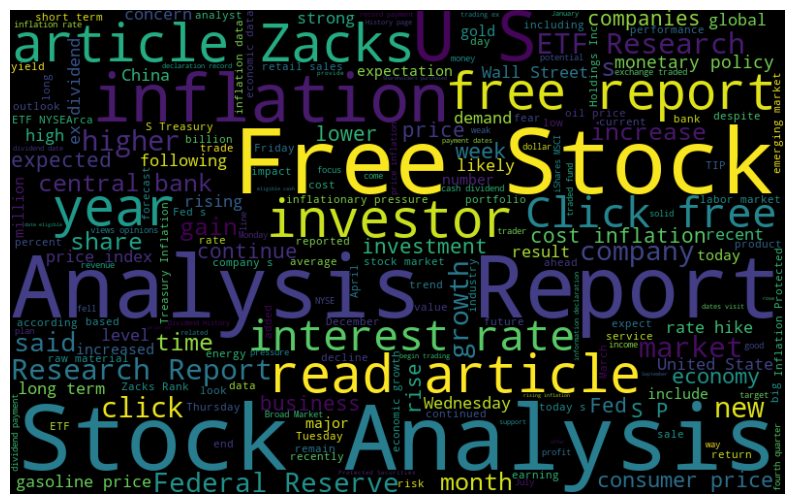

In [13]:
all_words = ' '.join([text for text in full_dataset['proc_summary']]) 

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

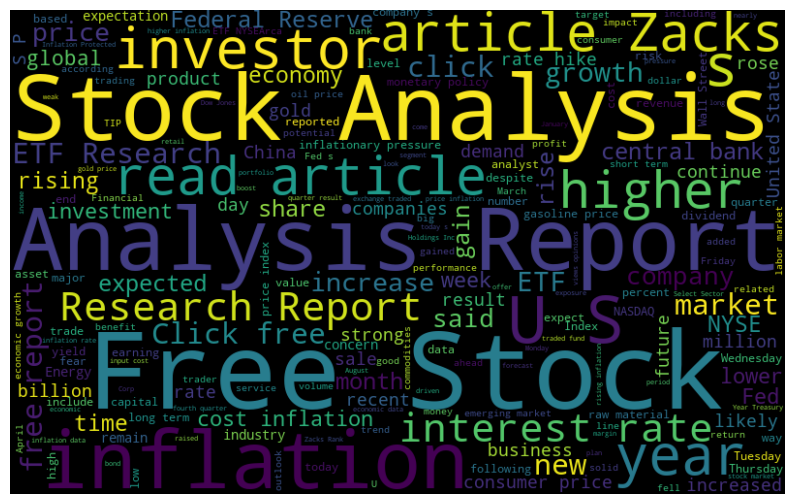

In [14]:
inflation_pos_words =' '.join([text for text in full_dataset['proc_summary'][full_dataset['label'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(inflation_pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

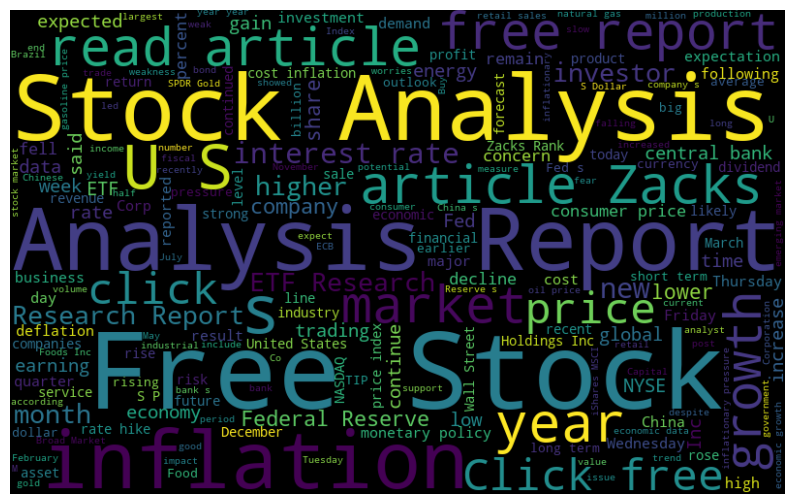

In [15]:
inflation_neg_words =' '.join([text for text in full_dataset['proc_summary'][full_dataset['label'] == -1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(inflation_neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

- Let's construct Word2vec Embeddings

**1. Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram** model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.

![imgur](https://i.imgur.com/f77V0dH.png)

There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

* It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

* Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using **pre-trained word vectors** instead of training our own model. Some of the freely available pre-trained vectors are:

1. [Google News Word Vectors](https://code.google.com/archive/p/word2vec/)

1. [Freebase names](https://code.google.com/archive/p/word2vec/)

1. [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec#prebuilt-models)

However, for now, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.

In [16]:
model_w2v = gensim.models.Word2Vec(
            full_dataset['tokens'],
            window=8, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(full_dataset['tokens'], total_examples=len(full_dataset['proc_summary']), epochs=20)

(4420991, 4872380)

In [17]:
# Function to average word vectors for each summary
def avg_word_vectors(tokens, model, vector_size):
    word_vectors = []
    for word in tokens:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Apply the function to create embeddings for each summary
full_dataset['embeddings'] = full_dataset['tokens'].apply(lambda x: avg_word_vectors(x, model_w2v, 100))

- using GloVe embeddings

In [18]:
glove_path = "../../data/glove.6B.100d.txt"

def load_glove_embeddings(file_path):
    " Load embeddings "
    
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings(glove_path)
embedding_dim = 100

In [19]:
def get_average_embedding(tokens, embeddings_index, embedding_dim):
    valid_embeddings = [embeddings_index[word] for word in tokens if word in embeddings_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

# Get embeddings
full_dataset['glove_embeddings'] = full_dataset['tokens'].apply(lambda x: get_average_embedding(x, embeddings_index, embedding_dim))

In [20]:
full_dataset.head(3)

,Summary,Date,label,YearMonth,proc_summary,tokens,embeddings,glove_embeddings
0,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,-1.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s adjusted inflation GDP population growth U S wasn t printing money ...,"[Today, United, States, wakes, 2, smokes, joint, goes, shopping, designer, clothes, Italy, yells, cashier, finds, card, s, limit, exceeded, In, 1940s, adjusted, inflation, GDP, population, growth,...","[-0.15932783, 0.07015022, -0.044631977, 0.22270115, -0.3847275, 0.24525973, 0.015540199, -0.11099592, 0.2544226, 0.27432737, 0.20820938, 0.13305762, 0.32349244, -0.18329899, 0.22374982, -0.0020981...","[0.08997329, 0.23356068, 0.18872151, 0.06513687, -0.074325286, -0.14344797, -0.04594858, 0.21874405, -0.051583484, 0.02803997, 0.17472516, 0.090699315, -0.029822785, 0.14181724, 0.29990426, -0.115..."
1,"Today, the United States wakes up at 2, smokes a joint, goes shopping for designer clothes (made in Italy), and yells at the cashier when he or she finds out the card's limit has been exceeded. In...",2010-01-12 00:00:00+00:00,0.0,2010-01,Today United States wakes 2 smokes joint goes shopping designer clothes Italy yells cashier finds card s limit exceeded In 1940s Internet didn t exist lot easier people knowing 10 year Treasuries ...,"[Today, United, States, wakes, 2, smokes, joint, goes, shopping, designer, clothes, Italy, yells, cashier, finds, card, s, limit, exceeded, In, 1940s, Internet, didn, t, exist, lot, easier, people...","[-0.21504684, 0.07096181, -0.028834416, 0.33645043, -0.4676082, 0.25715968, 0.08804134, -0.099705435, 0.27124387, 0.28750622, 0.17540014, 0.06641976, 0.30216074, -0.2143882, 0.26100114, 0.02534729...","[0.12423469, 0.25121012, 0.16890743, -0.03189439, -0.13509247, -0.043771826, -0.104019605, 0.13626942, 0.10677019, 0.014265262, 0.1582675, 0.014836926, 0.04012842, 0.07951634, 0.22291045, -0.11977..."
2,Short treasuries via TBT. That 4.7% return on today's long bond would look pretty darn good if deflation hit the USA hard over the next decade or so. The Bottom Line: The bond market pretty much s...,2010-02-12 00:00:00+00:00,1.0,2010-02,Short treasuries TBT That 4 7 return today s long bond look pretty darn good deflation hit USA hard decade The Bottom Line The bond market pretty screamed inflation increasingly concerned trillion...,"[Short, treasuries, TBT, That, 4, 7, return, today, s, long, bond, look, pretty, darn, good, deflation, hit, USA, hard, decade, The, Bottom, Line, The, bond, market, pretty, screamed, inflation, i...","[-0.3113765, 0.26126164, 0.058473926, -0.051504232, -0.31407276, 0.42586055, 0.06944933, -0.13378109, -0.15468803, 0.5015927, 0.28631222, 0.07922945, 0.48875943, -0.21722458, 0.13430329, -0.037377...","[0.04849454, 0.3664951, 0.41306198, -0.10773838, -0.2443564, -0.24916491, -0.3455728, -0.1853301, -0.14749524, -0.20734045, 0.19504666, 0.18425648, -0.086844295, 0.037091613, 0.19282755, -0.064900..."


In [21]:
# Train test split
train_w2v = full_dataset.iloc[:LAST_TRAINING_NEWS_ID,:][['glove_embeddings', 'embeddings', 'label']]
test_w2v = full_dataset.iloc[LAST_TRAINING_NEWS_ID:,:][['glove_embeddings', 'embeddings', 'label']]

#### Models testing (Word2vec VS GloVe)

- Word2Vec from scratch

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 5, 'l1_ratio': 1.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.42777777777777776
Logistic Regression F1 Score: 0.3796690031597925
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 30, 'n_estimators': 200}
Random Forest Accuracy: 0.4166666666666667
Random Forest F1 Score: 0.3318904538341158
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.41388888888888886
SVM F1 Score: 0.3620185162418381
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
XGBOOST Accuracy: 0.4388888888888889
XGBOOST F1 Score: 0.39306571741684293
Model: Logistic Regression
Best Params: {'C': 5, 'l1_ratio

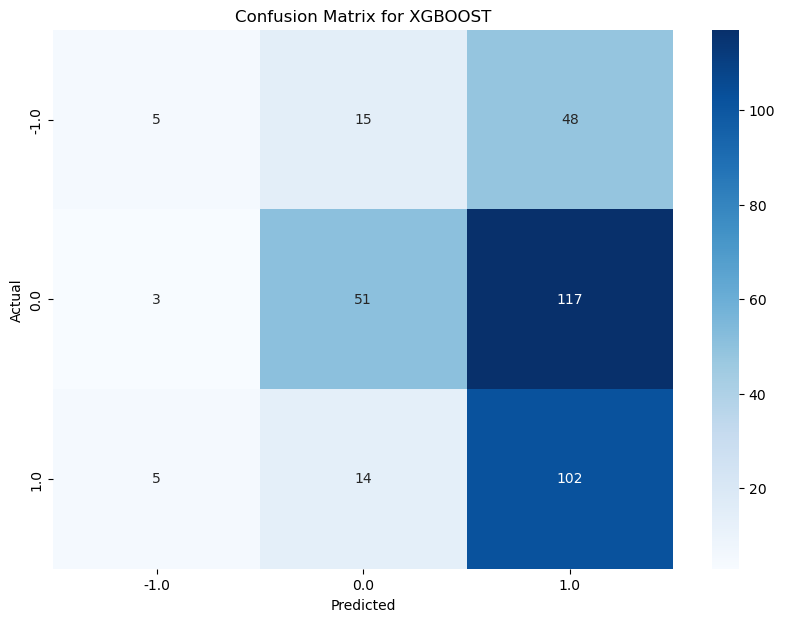

In [33]:
# Word2Vec
X_train_w2v = train_w2v['embeddings'].tolist()
X_test_w2v = test_w2v['embeddings'].tolist()
y_train_w2v = train_w2v['label'].tolist()
y_test_w2v = test_w2v['label'].tolist()

# Convert labels to non-negative integers if needed
unique_labels = np.unique(y_train_w2v)
label_map = {label: i for i, label in enumerate(unique_labels)}
y_train_w2v = np.array([label_map[label] for label in y_train_w2v])
y_test_w2v = np.array([label_map[label] for label in y_test_w2v])

# CV
results_w2v, best_models = grid_CV(X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, k=3)

# confusion map
show_confusion(results_w2v, best_models, X_test_w2v, y_test_w2v, unique_labels)


- GloVe Embeddings

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.4444444444444444
Logistic Regression F1 Score: 0.39675974690951654
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 200}
Random Forest Accuracy: 0.4388888888888889
Random Forest F1 Score: 0.3673010309700957
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.4
SVM F1 Score: 0.3358290221297002
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
XGBOOST Accuracy: 0.425
XGBOOST F1 Score: 0.3890370356047431
Model: Logistic Regression
Best Params: {'C': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Test Accuracy: 0.4444
Test F1 Score: 0.3968
Model: Random Forest
Best Params: {'max_depth': 20, 'n_estimators': 200}
Test Accuracy: 0.4389
Test F1 Score: 0.3673
Model: SVM
Best Params: {'C': 10, 'kernel': 'poly'}
Test Accuracy: 0.4000
Test F1 Score: 0.3358
Model: XGBOOST
Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Test Accuracy: 0.4250
Test F1 Score: 0.3890
Best Model: Logistic Regression
Best Params: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.0, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
F1 test 0.39675974690951654


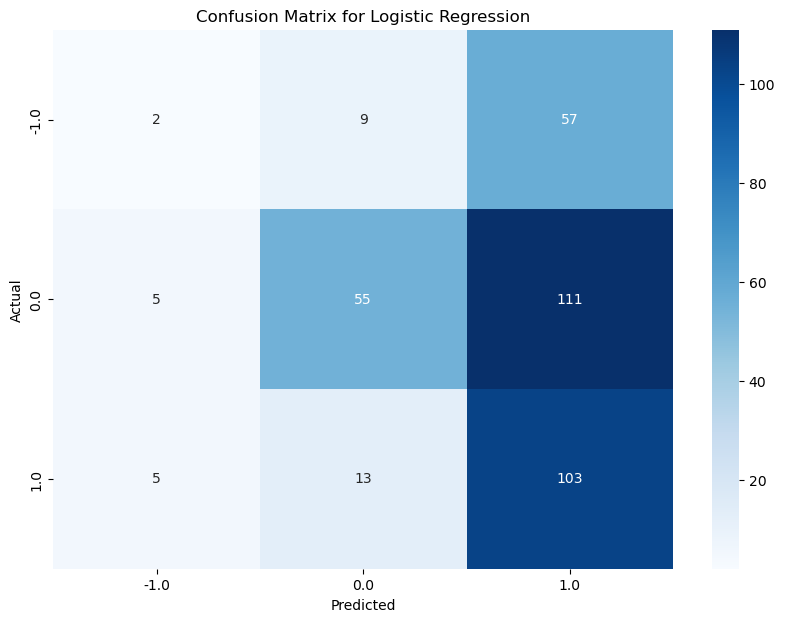

In [34]:
X_train_g = train_w2v['glove_embeddings'].tolist()
X_test_g = test_w2v['glove_embeddings'].tolist()
y_train_g = train_w2v['label'].tolist()
y_test_g = test_w2v['label'].tolist()

# Convert labels to non-negative integers if needed
unique_labels = np.unique(y_train_g)
label_map = {label: i for i, label in enumerate(unique_labels)}
y_train_g = np.array([label_map[label] for label in y_train_g])
y_test_g = np.array([label_map[label] for label in y_test_g])

# CV
results_glove, best_models = grid_CV(X_train_g, X_test_g, y_train_g, y_test_g, k=3)

# confusion map
show_confusion(results_glove, best_models, X_test_g, y_test_g, unique_labels)

> We note that GloVe is better

> In addition we can see that as the training data is imbalanced with lots more 1 class the model tends to overclassify class 1 during the test phase. Let's retrain but by undersampling the training dataset to have equal representation of all labels.

- Word2Vec under-sampled

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 0.2, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.4111111111111111
Logistic Regression F1 Score: 0.41408837434865925
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Random Forest Accuracy: 0.4027777777777778
Random Forest F1 Score: 0.40758611254988286
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.3888888888888889
SVM F1 Score: 0.38785497708091804
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 100, 'n_estimators': 200}
XGBOOST Accuracy: 0.43333333333333335
XGBOOST F1 Score: 0.43933476120971904
Model: Logistic Regression
Best Params: {'C': 0.2, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Test Accuracy: 0.4111
Test F1 Score: 0.4141
Model: Random Forest
Best Params: {'max_depth': None, 'n_estimators': 200}
Test Accuracy: 0.4028
Test F1 Score: 0.4076
Model: SVM
Best Params: {'C': 10, 'kernel': 'poly'}
Test Accuracy: 0.3889
Test F1 Score: 0.3879
Model: XGBOOST
Best Params: {'learning_rate': 0.2, 'max_depth': 100, 'n_estimators': 200}
Test Accuracy: 0.4333
Test F1 Score: 0.4393
Best Model: XGBOOST
Best Params: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': 

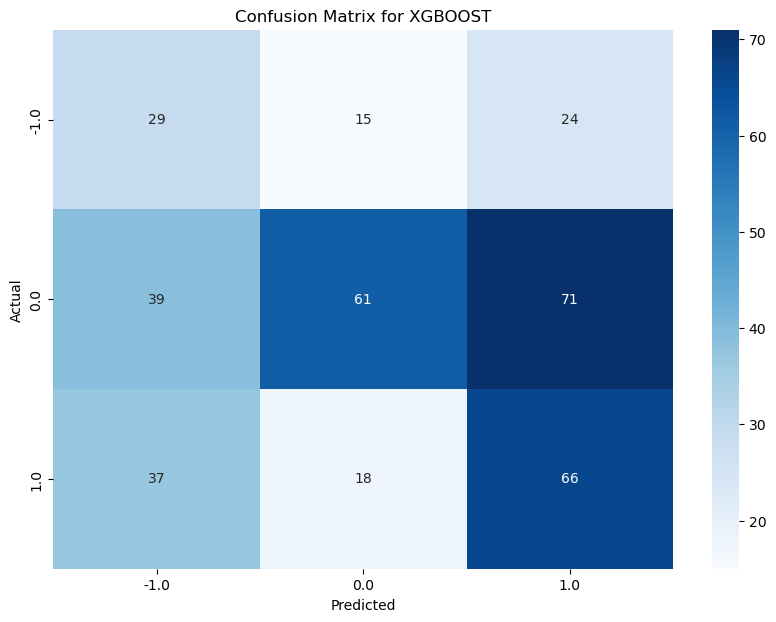

In [40]:
# CV
results_w2v, best_models = grid_CV(X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, k=3, undersampling=True)

# confusion map
show_confusion(results_w2v, best_models, X_test_w2v, y_test_w2v, unique_labels)

- GloVe under-sampled

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.4027777777777778
Logistic Regression F1 Score: 0.41265903723110536
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 200}
Random Forest Accuracy: 0.4166666666666667
Random Forest F1 Score: 0.42454787305359076
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.39166666666666666
SVM F1 Score: 0.39635939951247695
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBOOST Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGBOOST Accuracy: 0.4361111111111111
XGBOOST F1 Score: 0.4326684780990189
Model: Logistic Regression
Best Params: {'C': 1, 'l1_rati

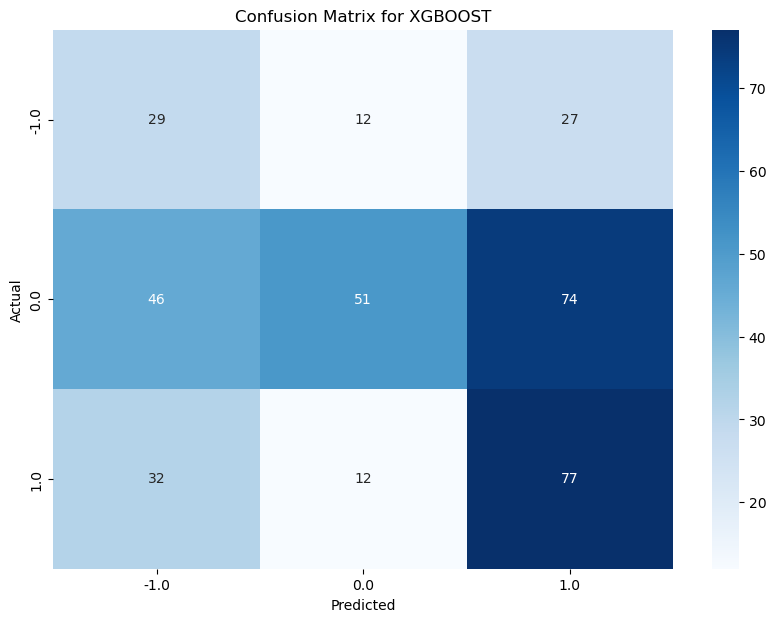

In [41]:
# CV
results_glove, best_models = grid_CV(X_train_g, X_test_g, y_train_g, y_test_g, k=3, undersampling=True)

# confusion map
show_confusion(results_glove, best_models, X_test_g, y_test_g, unique_labels)

- Under sampling was a good idea, we managed to increase the performance by 0.036 (3.6%)

- Next step is to use RNN to incorporate long terms dependecies that simple word2vec models are not able to identify. 

-> We will train a recurent Long Short Term Memory(LSTM) network

---
### Augmented dataset

- Augmented of the umbalanced class using a T5 paraphraser

In [12]:
training_news.label.value_counts()

label
 1.0    1781
 0.0    1336
-1.0     814
Name: count, dtype: int64

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [15]:
# split the dataset{summary x label}
X = training_news['summary']
y = training_news['label']

In [29]:
# Load the T5 paraphrasing model and tokenizer
paraphrase_tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
paraphrase_model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to('mps')

tokenizer_config.json: 100%|██████████| 2.32k/2.32k [00:00<00:00, 1.49MB/s]
spiece.model: 100%|██████████| 792k/792k [00:01<00:00, 624kB/s]
tokenizer.json: 100%|██████████| 2.42M/2.42M [00:01<00:00, 1.60MB/s]
special_tokens_map.json: 100%|██████████| 2.20k/2.20k [00:00<00:00, 3.30MB/s]
config.json: 100%|██████████| 1.61k/1.61k [00:00<00:00, 4.44MB/s]
pytorch_model.bin: 100%|██████████| 892M/892M [03:13<00:00, 4.61MB/s] 
generation_config.json: 100%|██████████| 147/147 [00:00<00:00, 372kB/s]


In [31]:
def paraphrase(
    question,
    num_beams=5,
    num_beam_groups=5,
    num_return_sequences=5,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = paraphrase_tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to('mps')
    
    outputs = paraphrase_model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = paraphrase_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res

# Test
paraphrases = paraphrase("If you want to avoid inflation, burn some cash", num_return_sequences=1)
print(paraphrases)

['To steer clear of inflation, it is advisable to use some money.']


In [24]:
desired_count = 2000

# Create a new DataFrame to store the upsampled data
upsampled_df = pd.DataFrame(columns=['summary', 'label'])

# Upsample each class
for label in y.unique():
    class_df = training_news[training_news['label'] == label]
    current_count = len(class_df)

    # If current count is less than the desired count, generate additional samples
    while current_count < desired_count:
        text_to_paraphrase = class_df['Summary'].sample(1).iloc[0]
        paraphrase = paraphrase(text_to_paraphrase, num_return_sequences=1)[0]
        upsampled_df = upsampled_df._append({'Summary': paraphrase, 'label': label}, ignore_index=True)
        current_count += 1
    print(f"Label {label}: DONE")
    upsampled_df = upsampled_df._append(class_df, ignore_index=True)

# Shuffle the DataFrame
upsampled_df = upsampled_df.sample(frac=1).reset_index(drop=True)

# Check the new class distribution
upsampled_df['label'].value_counts()